# Built-in Data, Multilayer Perceptrons, Training Loops

This notebook runs through a step-by-step implementation of dense (MLP) neural network for classification purposes. We'll go through the following stages:


1. Obtain and set-up some data.
2. Create the network architecture and forward (inference) function.
3. Build the training function.
4. Train the model.
5. Evaluate the results.

First we need to install the neural network libraries. Note that if you're following along outside of a notebook you'll need to install these packages locally. More info here: https://pytorch.org/get-started/locally/

**How to use this notebook:** You can run through the page, executing each code block. However, I also suggest you code-along with the notebook in a local python script, and execute this on your own machine.

In [ ]:
!pip3 install torch torchaudio torchvision torchtext torchdata scikit-learn pandas

## Data Setup

We're going to use the Fashion MNIST dataset, which consists of grayscale images of various clothes, with a 28 by 28 pixel resolution.

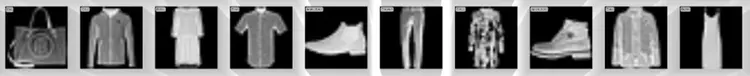

We'll import the necessary modules into Python, and then load the training and test data, which Pytorch helpfully provides for us. The data is encapsulated inside two instances of the Pytorch [Dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class) class.

This class (of which you can write your own - more on that later) generally contains logic for providing individual samples of data, as well as transforming/preprocessing/loading of data needed.

In [ ]:
import torch
import torchvision

The FashionMNIST dataset class lets us pass through some transformations which are then applied to each sample. We'll define a transform which turns each datapoint (a 28x28 numpy ndarray) into a Pytorch Tensor upon retrieval.

You could also add various normalisations/standardisations here, but for now we'll stick with the raw data.

In [1]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor()])

Load the datasets, passing in our transform via the `transform` parameter.


In [ ]:
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)

We can directly examine the output of a Dataset object through indexing:

In [ ]:
print(training_set[0])

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000

But this isn't particularly useful.

It's easier examine the shape of the data. This dataset returns data in a tuple of `(sample, label)`, so:



In [ ]:
print(type(training_set[0]))
x, y = training_set[0]
class_labels = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')
print(x.shape)
print(f"Class (numeric): {y}")
print(f"Class (labelled): {class_labels[y]}")

<class 'tuple'>
torch.Size([1, 28, 28])
Class (numeric): 9
Class (labelled): Ankle Boot


The data itself are images, and hence are returned as a tensor with a shape of (C, H, W), where C is the number of channels (1 = grayscale), and H and W are height and width. The shape of the data will vary depending on what the data is!

The class label is an integer between 0 and 9, which map to a specific class of image. Here, an integer of 9 refers to the "Ankle Boot" class.

We can verify this by plotting the output of the dataset with matplotlib to make sure we're getting out what we're expecting.

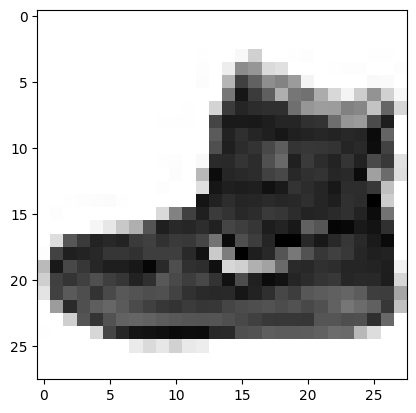

In [ ]:
%matplotlib inline
# Unless you're running in a notebook, ignore the above line.
import matplotlib.pyplot as plt
import numpy as np

# Turn the Pytorch tensor into a numpy array, as matplotlib can't handle Tensors.
npimg = x.numpy()
# "squeeze" removes axes of length 1,  i.e, turn a shape of (1, 28, 28) -> (28, 28)
npimg = np.squeeze(npimg)
plt.imshow(npimg, cmap="Greys")
plt.show()

This takes care of handling individual datapoints - but we need to be able to load a greater quantity of data into a "batch", as well as iterate repeatedly through the data to train the model.

We can do this with Pytorch [Dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders), which build off of our Datasets

In [ ]:
training_loader = torch.utils.data.DataLoader(training_set, batch_size=32, shuffle=True)

As before, we can verify the output of a Dataloader to make sure everything looks sensible. Note the shape of the data (including the labels) now matches the batch size we set above.

The data itself now follows the (N, C, H, W) format, where N is equal to the batch size. Basically, you've got N training samples, instead of the one you'd get by manually indexing the Dataset.

In [ ]:
batched_x, batched_y = next(iter(training_loader))
print(batched_x.shape)
print(batched_y.shape)
print(batched_y)

torch.Size([32, 1, 28, 28])
torch.Size([32])
tensor([1, 1, 2, 4, 4, 2, 6, 8, 3, 7, 5, 5, 2, 4, 2, 9, 8, 3, 2, 4, 4, 9, 5, 8,
        3, 0, 8, 9, 8, 5, 8, 6])


**With the data ready, we can now move on to the model.**


## Model architecture & forward propagation

We now need to define a model which we can train.

This is where we define the architecture and inference function.

We're going to use a relatively simple dense neural network as an introduction; although the techniques here generalise to many kinds of different architectures and approaches.

In Pytorch, you generally define your trainable layers as instance variables of the class. Here, we define three linear layers: 1 input layer, 1 hidden layer, and 1 output layer.

In the **forward function** we call these layers in sequence over the input; taking the output of the previous layer and feeding it into the next.

We also wrap the output of each layer in an **activation function** which is applied over the output. This adds non-linearity to the neural network, allowing it to approximate non-linear functions. There's a vast array of possible [activation](https://pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions) functions, with varying use-cases.

Generally, RELU works pretty well for intermediate network layers:

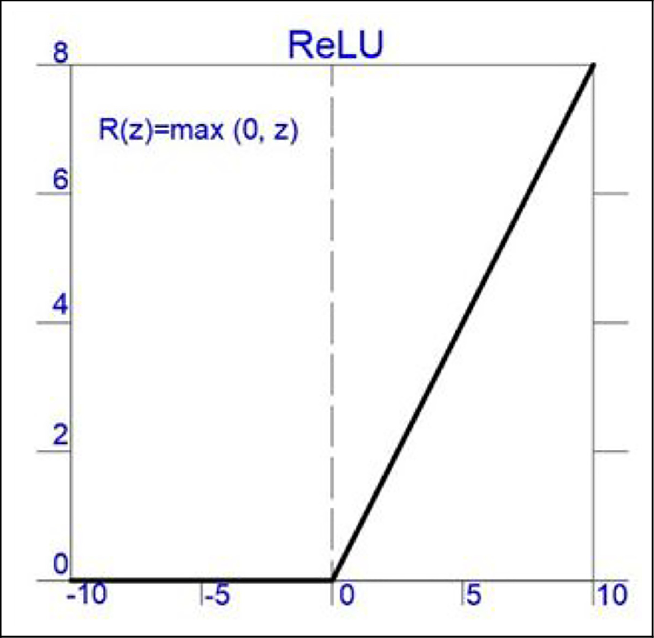

Note the non-linearity; all outputs below zero are set to zero.

**Important:** The data is 2D, but the linear layers expect a 1D input!

We can handle this by reshaping the data from 2D to a 1D vector in the forward function before it passes through to the first linear layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class FashionMNISTClassifier(nn.Module):
    def __init__(self):
        """
        Define the model in the init function of a class which inherits from
        nn.Module.

        Here, we're creating a fully connected network with one input layer,
        one hidden layer, and one output layer.

        The number of inputs in first layer needs to match the dimensionality
        of the data. We're mapping each pixel of the input image into a single
        neuron. As the image has a 28 by 28 pixel resolution, we need
        28 * 28 = 784 input neurons.
        """
        super(FashionMNISTClassifier, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        """
        Forward propagation function. Takes an input and performs the layer
        operations defined within.

        The activation function is a Rectified Linear Unit.

        x: The input batch

        Returns: The output after passing through the layers specified
        """

        # Reshape the 2D image data into a 1D vector
        x = x.view(-1, 28 * 28)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of our model class we can train.
model = FashionMNISTClassifier()

# Pass some random data forwards through the model.
random_data = torch.rand((1, 1, 28, 28))
random_out = model(random_data)
print(random_out)
print(random_out.shape)

tensor([[ 0.0431, -0.0085, -0.0910, -0.0395,  0.0160,  0.0457, -0.1323,  0.0217,
          0.0204, -0.0288]], grad_fn=<AddmmBackward0>)
torch.Size([1, 10])


## Loss Functions & Optimisers

Before training the network we also need to set up:

1.   A **loss function**, which tells us how different the network outputs are from the intended ground truth
2.   An **optimiser**: which controls how the network should respond to the error from the loss function.

We'll use cross entropy as the loss function, which is a standard loss for multi-class classification problems.

For the optimiser we'll use Stochastic Gradient Descent, though there are many more options [available](https://pytorch.org/docs/stable/optim.html) with which you can experiment.

First, we declare what we are optimising: in this case, the weights and biases (the parameters) of the model. Optimisers generally have a few tunable *hyperparameters* as well. Here, we can change the learning rate, which controls the size of the steps taken (i.e, how much are the models weights changed in response to the error?) and the momentum (if we're taking a lot of steps in the same direction, how much should we keep going in that direction?).

NB: Pytorch's CrossEntropyLoss lets us pass in unnormalised outputs, which don't need to sum to one.

In [ ]:
# The cross-entropy loss
loss_fn = torch.nn.CrossEntropyLoss()

# An SGD Optimiser
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Training Loop

We're now ready to define a training loop.

This will:

1. Gather training data and labels
2. Obtain model outputs for the training data (forward pass)
3. Compute the *loss* between the model outputs and the labels (ground truth)
4. Use the loss to update the weights and biases of the model (backward pass)
5. Repeat!

Generally the training loop runs for a set number of *epochs*. An epoch is one pass through the entire training data; and consists of multiple smaller batches of data.


In [ ]:
epoch_losses = []
EPOCHS = 10


for epoch in range(0, EPOCHS):
  epoch_loss = 0
  # Run in a loop for n epochs
  for idx, data in enumerate(training_loader):
    # Repeatedly pulls batches of data out of the training dataloader we defined earlier.
    inputs, labels = data

    # Zero the optimiser gradients for each batch
    # This is so that after each batch the error points in the correct direction
    # toward the minimum
    optimizer.zero_grad()

    # Forward pass over the inputs
    outputs = model(inputs)

    # Compute the loss
    loss = loss_fn(outputs, labels)

    # Compute the gradients
    loss.backward()

    # Backward pass to update weights
    optimizer.step()

    # Keep a running total of the losses from each batch for each epoch.
    epoch_loss += loss.item()

  # Print the loss (normalised by total batches)
  print(f"Epoch {epoch} loss: {epoch_loss / len(training_loader)}")
  epoch_losses.append(epoch_loss / len(training_loader))



Epoch 0 loss: 0.36752082075079284
Epoch 1 loss: 0.3586854064265887
Epoch 2 loss: 0.3501761857966582
Epoch 3 loss: 0.34190500708421073
Epoch 4 loss: 0.33448021117647486
Epoch 5 loss: 0.32952731265425683
Epoch 6 loss: 0.3218530921459198
Epoch 7 loss: 0.3152206789453824
Epoch 8 loss: 0.31000602104266484
Epoch 9 loss: 0.3040072491069635


## Evaluation

A natural first step is to graph the *loss curve*, which shows us the performance of the model over the training epochs. Generally this should show a smooth decreasing curve which asymptotically approaches some lower bound on performance.

If you're not seeing this (e.g, the loss does not decrease), it can be indicative of a problem with the data, model, or training process.

The steeper the loss curve, the quicker the network is converging - different optimiser and hyperparameter choices can affect this, and hence affect the total training time required!

In [2]:
plt.plot(range(0, len(epoch_losses)), epoch_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Curve")
plt.show()

NameError: name 'plt' is not defined

# Regression

You can also use an MLP for regression. Scikit-learn comes with a dataset suitable for this, which links various housing features to house price.

There's a skeleton of code for implementing this below - can you create a regression model which can be trained to predict housing prices?

( Example answer script at end of notebook)

In [ ]:
%matplotlib inline
# Unless you're running in a notebook, ignore the above line.
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set up the data
data = fetch_california_housing()
print(data.feature_names)

X, y = data.data, data.target

# Convert to tensors
X_train = torch.tensor(X, dtype=torch.float32)
# The reshape adds a singleton dimension which torch expects.
y_train = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32)

# Set up the loss function and optimiser. You can change this if you like
loss_fn = torch.nn.MSELoss()  # Loss

EPOCHS = 10

# =========================================================
#           Try filling in the skeleton below.
#               (Model + Training Loop)
# =========================================================

# =================== MODEL ===================

class HousingPriceModel(nn.Module):
    def __init__(self):
        super(HousingPriceModel, self).__init__()
        # Define your layers here

    def forward(self, x):
        # Define the forward function here.
        return x

model = HousingPriceModel()
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.9) # Optimiser

# =================== MODEL ===================

# Some storage for your epoch losses
epoch_losses = []

# =================== TRAINING LOOP ===================

for epoch in range(0, EPOCHS):
  # Add your training code here.

# =================== TRAINING LOOP ===================

plt.plot(range(0, len(epoch_losses)), epoch_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Curve")
plt.show()

IndentationError: expected an indented block after 'for' statement on line 54 (<ipython-input-24-80c67a14e943>, line 59)

# Further exploration

**You've now completed this notebook**

However, there's plenty more to be discovered. Consider playing around with the following questions by editing your training script or by taking a copy of this notebook.

You don't have to tackle these in order.

**What happens if you change the optimiser hyperparameters? By:**
1.  ...changing the learning rate?
2. ...altering the momentum?


**What happens if you train for more epochs?**

1. At which point are there diminishing returns on accuracy?

**Can you improve the performance of the network?**
(This doesn't just mean accuracy - can you get the network to converge in less epochs?)
1. By adding more layers?
2. By using a different optimiser?
3. By using a different activation function?
4. By preprocessing the input data?

```
transforms.Normalize((0.5,), (0.5,))
```

**Why might we want to use a more specialised network type for image data?**

(Hint: see below)


In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Total network parameters: {pytorch_total_params}")

Total network parameters: 105214


## Regression example script

In [ ]:
%matplotlib inline
# Unless you're running in a notebook, ignore the above line.
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import torch


# Set up the data
data = fetch_california_housing()
print(data.feature_names)

X, y = data.data, data.target

# Convert to tensors
X_train = torch.tensor(X, dtype=torch.float32)
# The reshape adds a singleton dimension which torch expects.
y_train = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32)

import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class HousingPriceModel(nn.Module):
    def __init__(self):
        super(HousingPriceModel, self).__init__()
        self.fc1 = torch.nn.Linear(8, 32)
        self.fc2 = torch.nn.Linear(32, 16)
        self.fc3 = torch.nn.Linear(16, 8)
        self.fc4 = torch.nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = HousingPriceModel()
# Set up the loss function and optimiser
loss_fn = torch.nn.MSELoss()  # Loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.9) # Optimiser
EPOCHS = 10
epoch_losses = []
batch_losses = []

for epoch in range(0, EPOCHS):
  epoch_loss = 0
  # Run in a loop for n epochs
  for idx, data in enumerate(train_loader):
    # Repeatedly pulls batches of data out of the training dataloader we defined earlier.
    inputs, labels = data

    # Zero the optimiser gradients for each batch
    # This is so that after each batch the error points in the correct direction
    # toward the minimum
    optimizer.zero_grad()

    # Forward pass over the inputs
    outputs = model(inputs)

    # Compute the loss
    loss = loss_fn(outputs, labels)

    # Compute the gradients
    loss.backward()

    # Backward pass to update weights
    optimizer.step()

    # Keep a running total of the losses from each batch for each epoch.
    epoch_loss += loss.item()
    batch_losses.append(loss.item() / len(inputs))

  # Print the loss (normalised by total batches)
  print(f"Epoch {epoch} loss: {epoch_loss / len(train_loader)}")
  epoch_losses.append(epoch_loss / len(train_loader))

plt.plot(range(0, len(epoch_losses)), epoch_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Curve")
plt.show()